In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import timm
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

C:\Users\atom\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
path = 'train_audio'
bs = 64

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=0.5, std=0.25)
])

In [5]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    augmented_data = np.clip(augmented_data, -1, 1)
    return augmented_data

In [6]:
class CustomDataset(Dataset):
    def __init__(self, audio, labels, transform=None, spectrogram_type='mel', augment_audio=False):
        self.audios_path = audio
        self.labels = labels
        self.transform = transform
        self.spectrogram_type = spectrogram_type
        self.augment_audio=augment_audio

    def __len__(self):
        return len(self.audios_path)

    def __getitem__(self, index):
        top_db_c = 10
        y, sr = librosa.load(self.audios_path[index])
        
        original_duration = librosa.get_duration(y=y, sr=sr)
        # print(f"Original duration: {original_duration:.2f} seconds")
        
        non_silent_intervals = librosa.effects.split(y, top_db=top_db_c)
        y = np.concatenate([y[start:end] for start, end in non_silent_intervals])

        new_duration = librosa.get_duration(y=y, sr=sr)
        while new_duration >= 4.0:
            top_db_c -= 1
            non_silent_intervals = librosa.effects.split(y, top_db=top_db_c)
            if len(non_silent_intervals) < 1: 
                # print(top_db_c)
                break
            y = np.concatenate([y[start:end] for start, end in non_silent_intervals])
            new_duration = librosa.get_duration(y=y, sr=sr)
            
        # print(f"Duration after removing silence: {new_duration:.2f} seconds")

              
        if self.augment_audio:
            y = add_noise(y)
        
        if self.spectrogram_type == 'mel': # mel spectrogram
            spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        elif self.spectrogram_type == 'stft': # Short-Time Fourier Transform  spectrogram
            D = librosa.stft(y)
            spectrogram = np.abs(D)
        elif self.spectrogram_type == 'cqt': # constant-Q Transform spectrogram
            C = librosa.cqt(y, sr=sr)
            spectrogram = np.abs(C)
        elif self.spectrogram_type == 'chroma': # chroma spectrogram 
            spectrogram = librosa.feature.chroma_stft(y=y, sr=sr)
        elif self.spectrogram_type == 'sc': # spectral contrast spectrogram
            spectrogram = librosa.feature.spectral_contrast(y=y, sr=sr)
        else:
            raise ValueError(f"Unsupported spectrogram type: {self.spectrogram_type}")
        
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        # print(spectrogram.shape)
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        return spectrogram, self.labels[index]

In [7]:
def load_data_paths(root_dir):
    audio_files = [f for f in os.listdir(root_dir) if f.endswith('.ogg')]
    paths = [os.path.join(root_dir, f) for f in audio_files]
    return paths

In [8]:
x_train, x_val = [], []
y_train, y_val = [], []

In [9]:
for folder in os.listdir(path):
    root = os.path.join(path, folder)
    files = [os.path.join(root, f) for f in os.listdir(root)]
    labels = [folder] * len(files)
    
    x_train_folder, x_val_folder, y_train_folder, y_val_folder = train_test_split(files, labels, test_size=0.2, random_state=42)
    
    x_train.extend(x_train_folder)
    x_val.extend(x_val_folder)
    y_train.extend(y_train_folder)
    y_val.extend(y_val_folder)

In [10]:
labels = os.listdir(path)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(encoded_labels)
print(labels)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1', 'aspfly1', 'aspswi1', 'barfly1', 'barswa', 'bcnher', 'bkcbul1', 'bkrfla1', 'bkskit1', 'bkwsti', 'bladro1', 'blaeag1', 'blakit1', 'blhori1', 'blnmon1', 'blrwar1', 'bncwoo3', 'brakit1', 'brasta1',

In [11]:
dataset_train_mel = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='mel')
dataset_val_mel = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='mel')

dataset_train_constantQ = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='cqt')
dataset_val_constantQ = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='cqt')

dataset_train_contrast = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='sc')
dataset_val_contrast = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='sc')

dataset_train_chroma = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='chroma')
dataset_val_chroma = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='chroma')

dataset_train_stft = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='stft')
dataset_val_stft = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='stft')

dataset_train_mel_aug = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='mel', augment_audio=True)
dataset_val_mel_aug = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='mel', augment_audio=True)

In [12]:
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=9):
    # print(next(model.parameters()).device)
    loss_list = []
    loss_list_val = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    loss_total = []
    loss_total_val = []
    accuracy_total = []
    precision_total = []
    recall_total = []
    f1_total = []
    
    len_loader = len(train_loader)
    model.train()
    for epoch in range(num_epochs):
        i = 1
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        for inputs, labels in train_loader:
            # if i == 10: break
            
            print(f'\rIteration: {i} / {len_loader}', end='', flush=True)
            i += 1
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            # print(inputs.device.type == 'cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

            # if i == 5: break
            
        print('\nValidating...')
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
                predictions = torch.argmax(outputs, dim=1)
                accuracy = accuracy_score(labels.cpu(), predictions.detach().cpu())
                precision = precision_score(labels.cpu(), predictions.detach().cpu(), average='macro')
                recall = recall_score(labels.cpu(), predictions.detach().cpu(), average='macro')
                f1 = f1_score(labels.cpu(), predictions.detach().cpu(), average='macro')

                loss_list_val.append(loss.item())
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)
        
                # print(f'Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')
                # if i == 5: break
       

        loss = sum(loss_list) / len(loss_list)
        loss_val = sum(loss_list_val) / len(loss_list_val)
        accuracy = sum(accuracy_list) / len(accuracy_list)
        precision = sum(precision_list) / len(precision_list)
        recall = sum(recall_list) / len(recall_list)
        f1 = sum(f1_list) / len(f1_list)

        loss_total.append(loss)
        loss_total_val.append(loss_val)
        accuracy_total.append(accuracy)
        precision_total.append(precision)
        recall_total.append(recall)
        f1_total.append(f1)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {loss:.3f}, Validation loss: {loss_val:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}\n')

    plt.plot(loss_total)
    plt.title('Train loss')
    plt.show()
    plt.plot(loss_total_val)
    plt.title('Validation loss')
    plt.show()
    plt.plot(accuracy_total, label='Accuracy')
    plt.plot(precision_total, label='Precision')
    plt.plot(recall_total, label='Recall')
    plt.plot(f1_total, label='F1-score')
    plt.legend()
    plt.show()

In [13]:
class ResNetGray182(nn.Module):
    def __init__(self, num_classes=182):
        super(ResNetGray182, self).__init__()
        resnet = models.resnet18(pretrained=False)
        # Изменяем первый слой, чтобы он принимал одноканальные изображения
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Копируем веса из оригинальной модели ResNet
        self.conv1.weight.data = resnet.conv1.weight.data.sum(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        # Изменяем последний полносвязный слой для 182 классов
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [14]:
train_loader_mel = DataLoader(dataset_train_mel, batch_size=bs, shuffle=True)
train_loader_contrast = DataLoader(dataset_train_contrast, batch_size=bs, shuffle=True)
train_loader_constantQ = DataLoader(dataset_train_constantQ, batch_size=bs, shuffle=True)
train_loader_stft = DataLoader(dataset_train_stft, batch_size=bs, shuffle=True)
train_loader_chroma = DataLoader(dataset_train_chroma, batch_size=bs, shuffle=True)
train_loader_mel_aug = DataLoader(dataset_train_mel_aug, batch_size=bs, shuffle=True)

val_loader_mel = DataLoader(dataset_val_mel, batch_size=bs, shuffle=True)
val_loader_contrast = DataLoader(dataset_val_contrast, batch_size=bs, shuffle=True)
val_loader_constantQ = DataLoader(dataset_val_constantQ, batch_size=bs, shuffle=True)
val_loader_stft = DataLoader(dataset_val_stft, batch_size=bs, shuffle=True)
val_loader_chroma = DataLoader(dataset_val_chroma, batch_size=bs, shuffle=True)

In [15]:
def launch(train_loader, val_loader, num_epochs=9, spectrogram_type='mel'):
    model = ResNetGray182(num_classes=182).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # print(next(model.parameters()).device)
    
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    
    torch.save(model.state_dict(), f'EfficientNet_weights{num_epochs}_{spectrogram_type}.pth')

# Model training on the mel spectogram

Iteration 305/305
Validating...
Epoch 1/7, Train loss: 3.191, Validation loss: 3.057, Accuracy: 0.307, Precision: 0.196, Recall: 0.222, F1-score: 0.193

Iteration 305/305
Validating...
Epoch 2/7, Train loss: 2.667, Validation loss: 2.793, Accuracy: 0.405, Precision: 0.269, Recall: 0.295, F1-score: 0.265

Iteration 305/305
Validating...
Epoch 3/7, Train loss: 2.273, Validation loss: 2.664, Accuracy: 0.440, Precision: 0.298, Recall: 0.315, F1-score: 0.290

Iteration 305/305
Validating...
Epoch 4/7, Train loss: 1.984, Validation loss: 2.554, Accuracy: 0.475, Precision: 0.325, Recall: 0.347, F1-score: 0.320

Iteration 305/305
Validating...
Epoch 5/7, Train loss: 1.701, Validation loss: 2.484, Accuracy: 0.496, Precision: 0.341, Recall: 0.366, F1-score: 0.337

Iteration 305/305
Validating...
Epoch 6/7, Train loss: 1.438, Validation loss: 2.431, Accuracy: 0.517, Precision: 0.371, Recall: 0.381, F1-score: 0.360

Iteration 305/305
Validating...
Epoch 7/7, Train loss: 1.118, Validation loss: 2.4

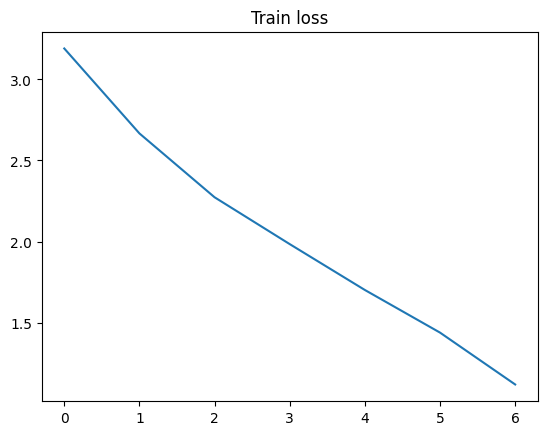

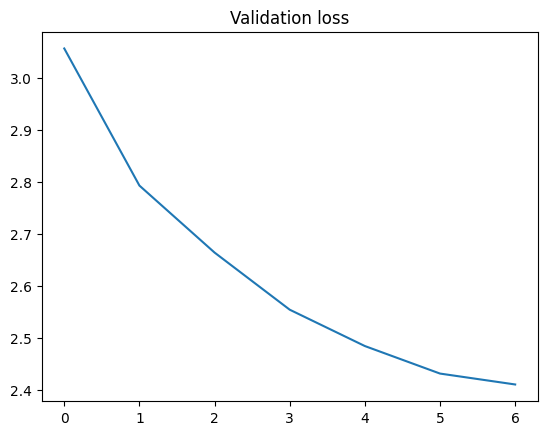

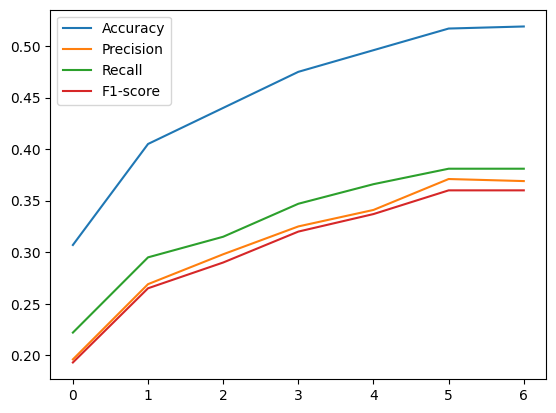

In [17]:
launch(train_loader=train_loader_mel, val_loader=val_loader_mel, num_epochs=7, spectrogram_type='mel')

In [18]:
loss_list = []
loss_list_val = []
accuracy_list = []
precision_list = []
recall_list = [] 
f1_list = []

loss_total = []
loss_total_val = []
accuracy_total = []
precision_total = []
recall_total = []
f1_total = []

# Model training on the spectral contrast

Iteration 305/305
Validating...
Epoch 1/9, Train loss: 4.037, Validation loss: 3.773, Accuracy: 0.155, Precision: 0.079, Recall: 0.113, F1-score: 0.083

Iteration 305/305
Validating...
Epoch 2/9, Train loss: 3.757, Validation loss: 3.736, Accuracy: 0.160, Precision: 0.084, Recall: 0.115, F1-score: 0.085

Iteration 305/305
Validating...
Epoch 3/9, Train loss: 3.523, Validation loss: 3.660, Accuracy: 0.196, Precision: 0.110, Recall: 0.138, F1-score: 0.110

Iteration 305/305
Validating...
Epoch 4/9, Train loss: 3.400, Validation loss: 3.602, Accuracy: 0.221, Precision: 0.128, Recall: 0.157, F1-score: 0.128

Iteration 305/305
Validating...
Epoch 5/9, Train loss: 3.250, Validation loss: 3.556, Accuracy: 0.231, Precision: 0.139, Recall: 0.160, F1-score: 0.137

Iteration 305/305
Validating...
Epoch 6/9, Train loss: 3.114, Validation loss: 3.516, Accuracy: 0.241, Precision: 0.141, Recall: 0.169, F1-score: 0.141

Iteration 305/305
Validating...
Epoch 7/9, Train loss: 2.964, Validation loss: 3.4

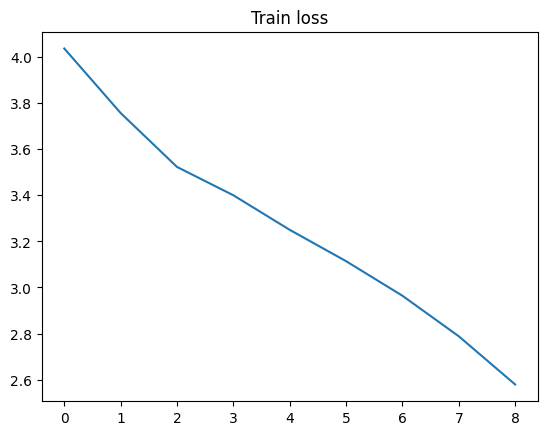

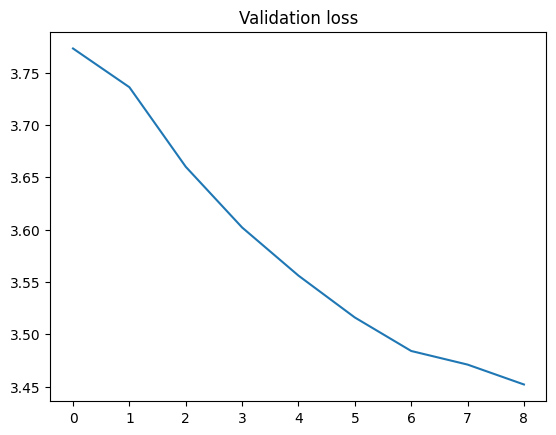

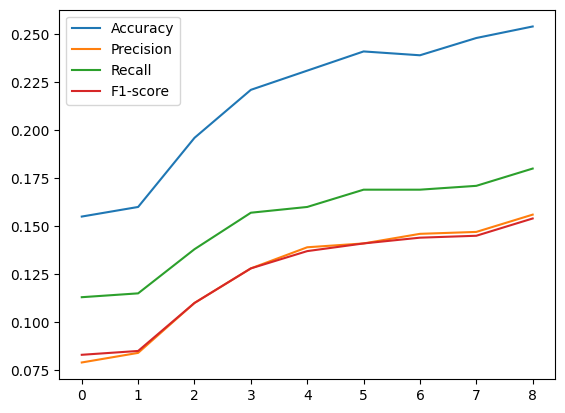

In [20]:
launch(train_loader=train_loader_contrast, val_loader=val_loader_contrast, num_epochs=9, spectrogram_type='sc')

# Model training on the constant-Q spectrogram

Iteration 305/305
Validating...
Epoch 1/7, Train loss: 3.792, Validation loss: 3.647, Accuracy: 0.195, Precision: 0.108, Recall: 0.145, F1-score: 0.112

Iteration 305/305
Validating...
Epoch 2/7, Train loss: 3.357, Validation loss: 3.448, Accuracy: 0.251, Precision: 0.154, Recall: 0.185, F1-score: 0.155

Iteration 305/305
Validating...
Epoch 3/7, Train loss: 3.056, Validation loss: 3.364, Accuracy: 0.263, Precision: 0.170, Recall: 0.192, F1-score: 0.167

Iteration 305/305
Validating...
Epoch 4/7, Train loss: 2.840, Validation loss: 3.285, Accuracy: 0.311, Precision: 0.204, Recall: 0.227, F1-score: 0.201

Iteration 305/305
Validating...
Epoch 5/7, Train loss: 2.620, Validation loss: 3.219, Accuracy: 0.324, Precision: 0.220, Recall: 0.239, F1-score: 0.215

Iteration 305/305
Validating...
Epoch 6/7, Train loss: 2.376, Validation loss: 3.176, Accuracy: 0.331, Precision: 0.217, Recall: 0.236, F1-score: 0.213

Iteration 305/305
Validating...
Epoch 7/7, Train loss: 2.091, Validation loss: 3.1

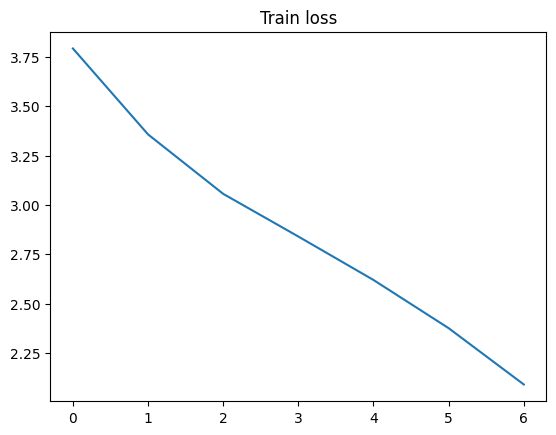

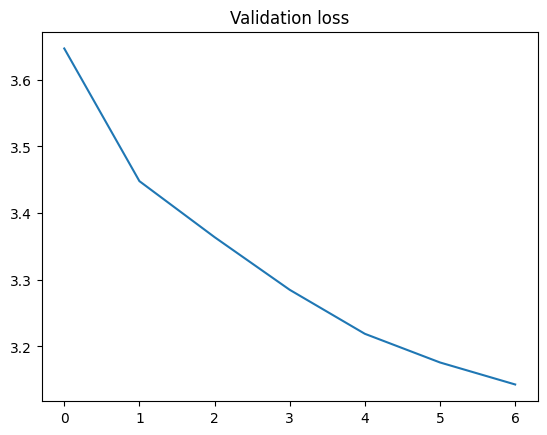

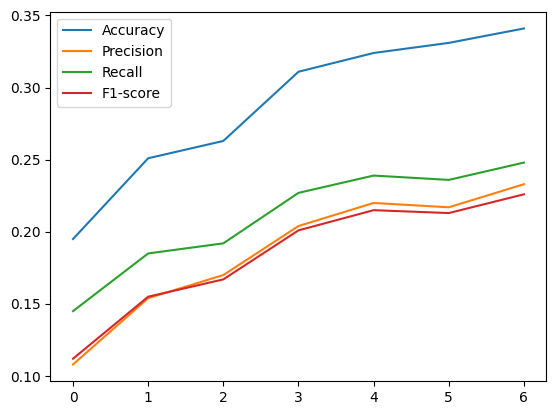

In [22]:
launch(train_loader=train_loader_constantQ, val_loader=val_loader_constantQ, num_epochs=7, spectrogram_type='cqt')

# Model training on the short-time fourier transform spectrogram

Iteration 305/305
Validating...
Epoch 1/6, Train loss: 3.385, Validation loss: 3.195, Accuracy: 0.271, Precision: 0.155, Recall: 0.191, F1-score: 0.155

Iteration 305/305
Validating...
Epoch 2/6, Train loss: 2.856, Validation loss: 2.943, Accuracy: 0.370, Precision: 0.233, Recall: 0.261, F1-score: 0.230

Iteration 305/305
Validating...
Epoch 3/6, Train loss: 2.437, Validation loss: 2.813, Accuracy: 0.399, Precision: 0.262, Recall: 0.279, F1-score: 0.255

Iteration 305/305
Validating...
Epoch 4/6, Train loss: 2.151, Validation loss: 2.686, Accuracy: 0.461, Precision: 0.313, Recall: 0.335, F1-score: 0.307

Iteration 305/305
Validating...
Epoch 5/6, Train loss: 1.878, Validation loss: 2.601, Accuracy: 0.479, Precision: 0.337, Recall: 0.352, F1-score: 0.328

Iteration 305/305
Validating...
Epoch 6/6, Train loss: 1.615, Validation loss: 2.541, Accuracy: 0.500, Precision: 0.338, Recall: 0.356, F1-score: 0.332


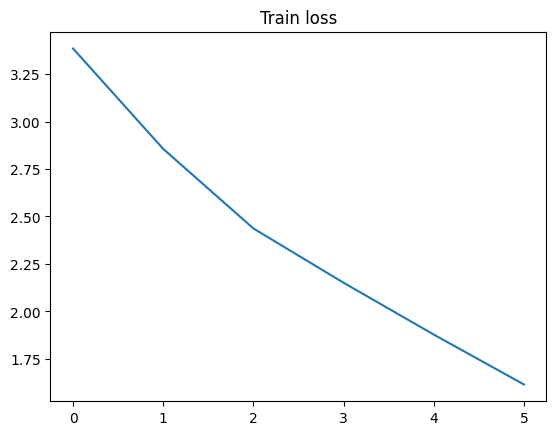

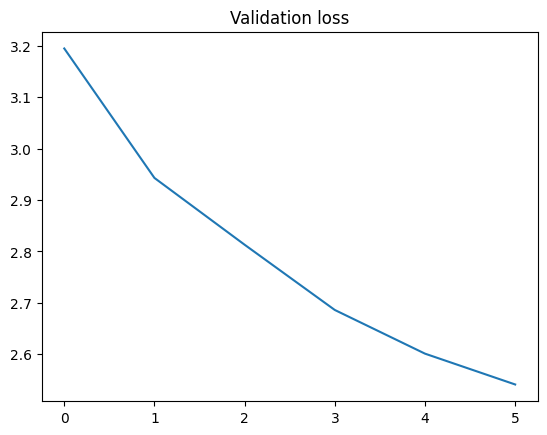

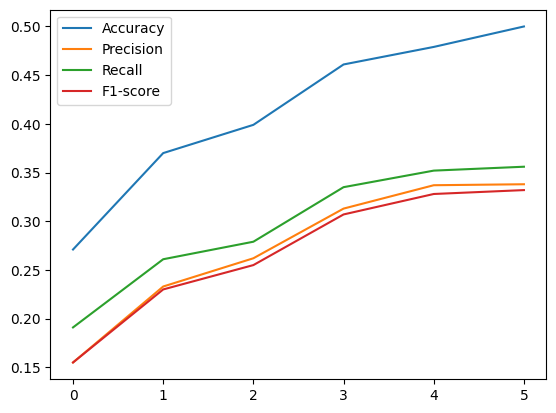

In [28]:
launch(train_loader=train_loader_stft, val_loader=val_loader_stft, num_epochs=6, spectrogram_type='stft')

# Model training on the chroma contrast

Iteration 305/305
Validating...
Epoch 1/8, Train loss: 4.172, Validation loss: 3.991, Accuracy: 0.148, Precision: 0.075, Recall: 0.107, F1-score: 0.078

Iteration 305/305
Validating...
Epoch 2/8, Train loss: 3.916, Validation loss: 3.895, Accuracy: 0.179, Precision: 0.103, Recall: 0.128, F1-score: 0.101

Iteration 305/305
Validating...
Epoch 3/8, Train loss: 3.618, Validation loss: 3.831, Accuracy: 0.204, Precision: 0.117, Recall: 0.143, F1-score: 0.115

Iteration 305/305
Validating...
Epoch 4/8, Train loss: 3.406, Validation loss: 3.748, Accuracy: 0.245, Precision: 0.142, Recall: 0.170, F1-score: 0.139

Iteration 305/305
Validating...
Epoch 5/8, Train loss: 3.187, Validation loss: 3.685, Accuracy: 0.258, Precision: 0.166, Recall: 0.183, F1-score: 0.159

Iteration 305/305
Validating...
Epoch 6/8, Train loss: 2.947, Validation loss: 3.634, Accuracy: 0.278, Precision: 0.173, Recall: 0.192, F1-score: 0.168

Iteration 305/305
Validating...
Epoch 7/8, Train loss: 2.682, Validation loss: 3.5

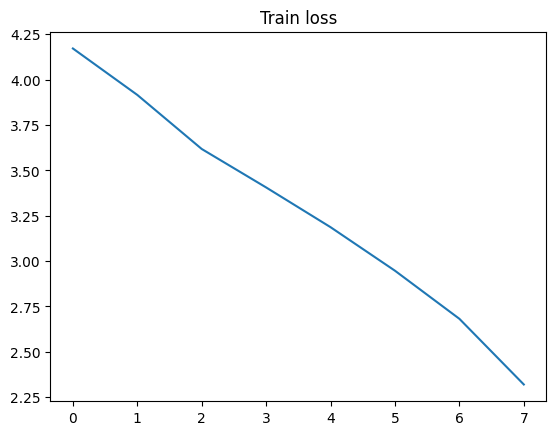

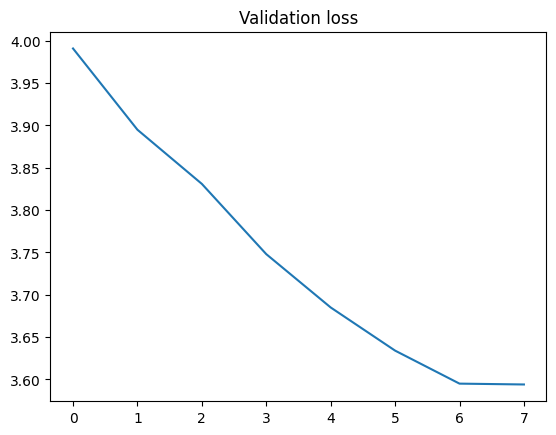

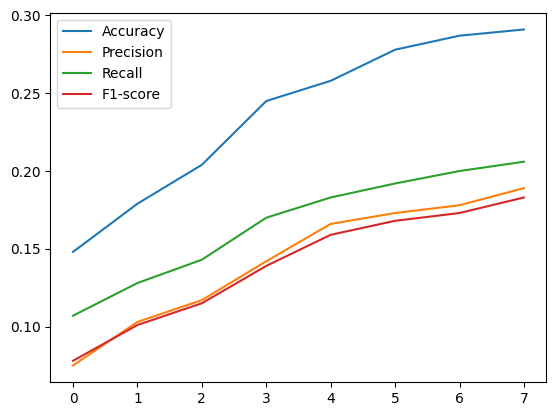

In [36]:
launch(train_loader=train_loader_chroma, val_loader=val_loader_chroma, num_epochs=8, spectrogram_type='chroma')

### As we can see, training on the mel spectrogram is the best, the results on the short-time fourier transform spectrogram's are close to it. Let's do an experiment:

# Model Training with label smoothing

In [31]:
loss_list = []
loss_list_val = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

loss_total = []
loss_total_val = []
accuracy_total = []
precision_total = []
recall_total = []
f1_total = []

In [32]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n = pred.size(1)
        smoothed_labels = torch.full(size=(target.size(0), n), fill_value=self.smoothing / (n - 1)).to(pred.device)
        smoothed_labels.scatter_(dim=1, index=target.unsqueeze(1), value=1 - self.smoothing)
        log_probs = nn.functional.log_softmax(pred, dim=1)
        loss = -torch.sum(smoothed_labels * log_probs, dim=1).mean()
        return loss

def launch_ls(train_loader, val_loader, num_epochs=9, spectrogram_type='mel'):  
    model = ResNetGray182(num_classes=182).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    
    torch.save(model.state_dict(), f'EfficientNet_weights{num_epochs}_{spectrogram_type}.pth')

Iteration 305/305
Validating...
Epoch 1/8, Train loss: 3.551, Validation loss: 3.232, Accuracy: 0.361, Precision: 0.221, Recall: 0.263, F1-score: 0.224

Iteration 305/305
Validating...
Epoch 2/8, Train loss: 3.146, Validation loss: 3.150, Accuracy: 0.399, Precision: 0.261, Recall: 0.292, F1-score: 0.258

Iteration 305/305
Validating...
Epoch 3/8, Train loss: 2.790, Validation loss: 3.056, Accuracy: 0.449, Precision: 0.302, Recall: 0.332, F1-score: 0.300

Iteration 305/305
Validating...
Epoch 4/8, Train loss: 2.563, Validation loss: 2.981, Accuracy: 0.467, Precision: 0.318, Recall: 0.348, F1-score: 0.315

Iteration 305/305
Validating...
Epoch 5/8, Train loss: 2.329, Validation loss: 2.924, Accuracy: 0.498, Precision: 0.352, Recall: 0.359, F1-score: 0.340

Iteration 305/305
Validating...
Epoch 6/8, Train loss: 2.087, Validation loss: 2.890, Accuracy: 0.512, Precision: 0.361, Recall: 0.373, F1-score: 0.352

Iteration 305/305
Validating...
Epoch 7/8, Train loss: 1.825, Validation loss: 2.8

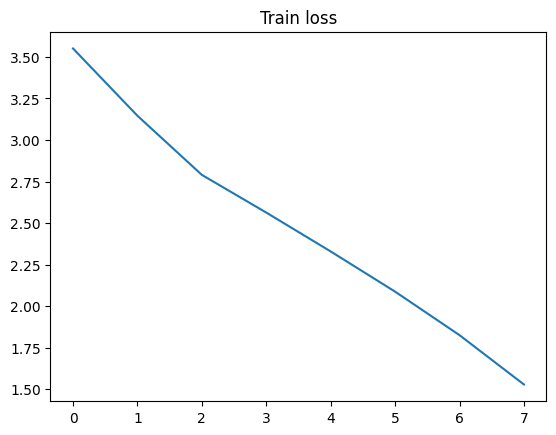

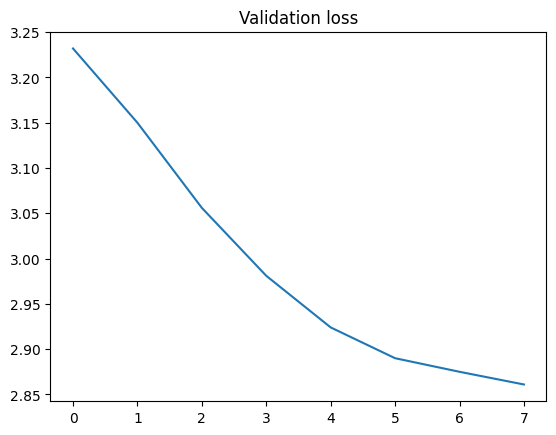

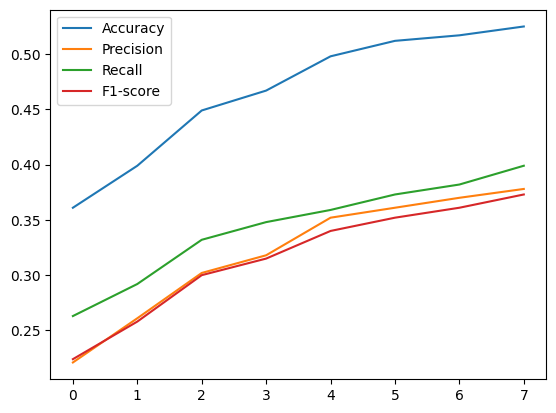

In [34]:
launch_ls(train_loader=train_loader_mel, val_loader=val_loader_mel, num_epochs=8, spectrogram_type='mel')

# Model training with augmentations

Iteration 305/305
Validating...
Epoch 1/7, Train loss: 3.289, Validation loss: 2.890, Accuracy: 0.332, Precision: 0.206, Recall: 0.226, F1-score: 0.202

Iteration 305/305
Validating...
Epoch 2/7, Train loss: 2.731, Validation loss: 2.785, Accuracy: 0.377, Precision: 0.239, Recall: 0.272, F1-score: 0.238

Iteration 305/305
Validating...
Epoch 3/7, Train loss: 2.379, Validation loss: 2.701, Accuracy: 0.410, Precision: 0.278, Recall: 0.291, F1-score: 0.268

Iteration 305/305
Validating...
Epoch 4/7, Train loss: 2.103, Validation loss: 2.621, Accuracy: 0.445, Precision: 0.307, Recall: 0.313, F1-score: 0.296

Iteration 305/305
Validating...
Epoch 5/7, Train loss: 1.855, Validation loss: 2.541, Accuracy: 0.498, Precision: 0.350, Recall: 0.362, F1-score: 0.340

Iteration 305/305
Validating...
Epoch 6/7, Train loss: 1.611, Validation loss: 2.515, Accuracy: 0.468, Precision: 0.333, Recall: 0.334, F1-score: 0.319

Iteration 305/305
Validating...
Epoch 7/7, Train loss: 1.331, Validation loss: 2.4

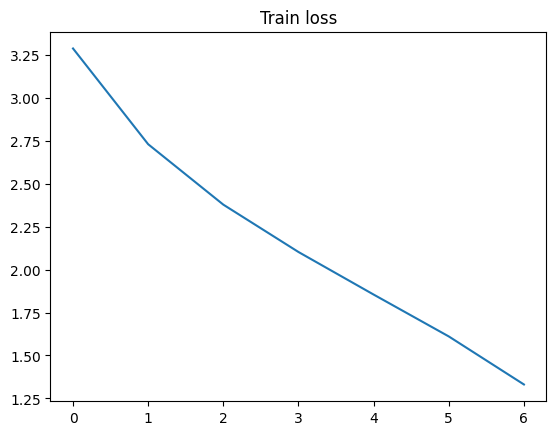

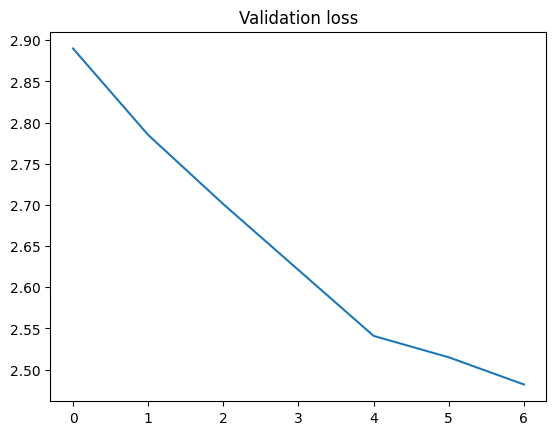

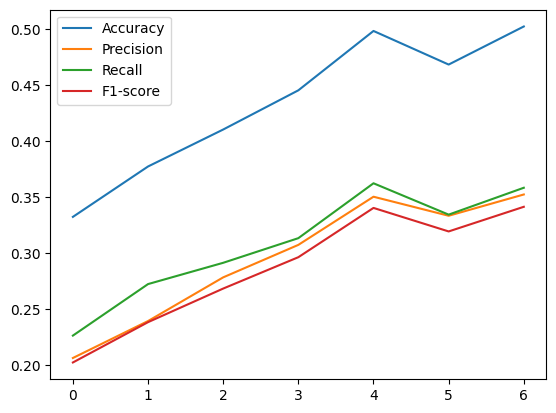

In [38]:
launch(train_loader=train_loader_mel_aug, val_loader=val_loader_mel, num_epochs=7, spectrogram_type='mel')